<a href="https://colab.research.google.com/github/SharatKhote/Exploratory-Data-Analysis/blob/main/Project_Taxi_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/NYC Taxi Data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Feature Creation

Let us create some new features from the existing variables so that we can gain more insights from the data.

In [5]:
# changing "pickup_datetime" and "dropoff_datetime" to datetime64[ns].
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

Now extracting and creating new features from this datetime features just created.

In [6]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

In [7]:
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday

In [8]:
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour

In [9]:
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

I have created the following features:

    pickup_day and dropoff_day which will contain the name of the day on which the ride was taken.
    pickup_day_no and dropoff_day_no which will contain the day number instead of characters with Monday=0 and Sunday=6.
    pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.
    pickup_month and dropoff_month with month number with January=1 and December=12.

Next, I have defined a function that lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [10]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

Now applying this function and create new columns in the dataset.

In [11]:
df['pickup_timeofday']=df['pickup_hour'].apply(time_of_day)
df['dropoff_timeofday']=df['dropoff_hour'].apply(time_of_day)

During dataset exploration I noticed that I have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that.
So, the most obvious feature that we can extract from this is distance.

In [12]:
pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# Importing the library which lets us calculate distance from geographical coordinates.
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [14]:
# Defining a function to take coordinates as inputs and return us distance.
from geopy.geocoders import Nominatim
def locator(Latitude,Longitude):
  geolocator = Nominatim(user_agent="geoapiExercises")
  location = geolocator.geocode(str(Latitude)+","+str(Longitude))
  
  return location


In [15]:
df['pickup_longitude'].value_counts()

-73.982201    633
-73.982140    607
-73.982101    587
-73.982117    585
-73.982224    584
             ... 
-73.815033      1
-73.882843      1
-73.844650      1
-73.854591      1
-73.841316      1
Name: pickup_longitude, Length: 23047, dtype: int64

In [16]:
# Importing the library which lets us calculate distance from geographical coordinates.
from geopy.distance import great_circle

In [17]:
# Defining a function to take coordinates as inputs and return us distance.
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [18]:
# Finally, applying the function to our dataset and creating the feature 'distance'.
df['distance'] = df.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

In [19]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_day,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,0,0,17,17,3,3,Evening,Evening,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,6,6,0,0,6,6,Late night,Late night,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,1,1,11,12,1,1,Morning,Afternoon,6.385108
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2,2,19,19,4,4,Evening,Evening,1.485501
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,5,5,13,13,3,3,Afternoon,Afternoon,1.188590


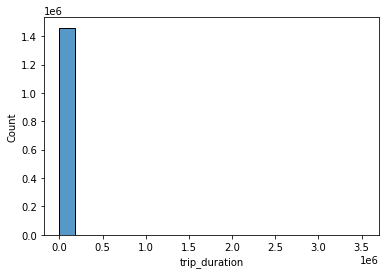

In [20]:
sns.histplot(df['trip_duration'],kde=False,bins=20)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


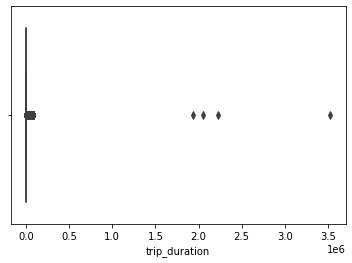

In [21]:
sns.boxplot(df['trip_duration'])

In [22]:
df['trip_duration'].sort_values(ascending=False)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
269418           1
467645           1
533799           1
726971           1
311745           1
Name: trip_duration, Length: 1458644, dtype: int64

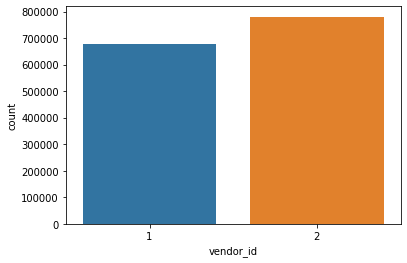

In [23]:
sns.countplot(x='vendor_id',data=df)

**Passenger** **Count**




In [24]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

passenger count

    There are some trips with even 0 passenger count.
    There is only 1 trip each for 8 and 9 passengers.
    There is only 3 trip for 7 passengers.


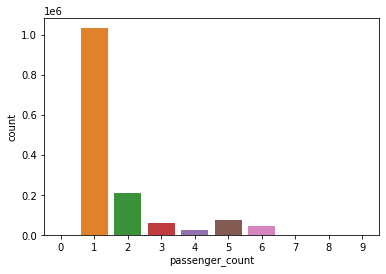

In [25]:
sns.countplot(x='passenger_count',data=df)

In [26]:
#We see the highest amount of trips are with 1 passenger.
#Let us remove the rows which have 0 or 7 or 8 or 9 passenger count.

df=df[df['passenger_count']!=0]
df=df[df['passenger_count']<=6]

In [27]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

In [28]:
df['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994486
Y    0.005514
Name: store_and_fwd_flag, dtype: float64

In [29]:
df['distance'].value_counts()

0.000000    5887
0.000424      45
0.000424      43
0.000424      35
0.000424      22
            ... 
3.231345       1
1.584861       1
0.434274       1
3.809274       1
1.134044       1
Name: distance, Length: 1452309, dtype: int64

We see there are 5887 trips with 0 km distance.

The reasons for 0 km distance can be:

    The dropoff location couldn’t be tracked.
    The driver deliberately took this ride to complete a target ride number.
    The passengers canceled the trip.

We will analyze these trips further in bivariate analysis.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458579 entries, 0 to 1458643
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458579 non-null  object        
 1   vendor_id           1458579 non-null  int64         
 2   pickup_datetime     1458579 non-null  datetime64[ns]
 3   dropoff_datetime    1458579 non-null  datetime64[ns]
 4   passenger_count     1458579 non-null  int64         
 5   pickup_longitude    1458579 non-null  float64       
 6   pickup_latitude     1458579 non-null  float64       
 7   dropoff_longitude   1458579 non-null  float64       
 8   dropoff_latitude    1458579 non-null  float64       
 9   store_and_fwd_flag  1458579 non-null  object        
 10  trip_duration       1458579 non-null  int64         
 11  pickup_day          1458579 non-null  object        
 12  dropoff_day         1458579 non-null  object        
 13  pickup_day_n

Creating two features of 'time in hour' and 'average speed in Kmph' beacause "distance = speed * time".

In [31]:
df['trip_duration_in_hour']=df['trip_duration'].apply(lambda x:x/3600)

In [32]:
df['avg_speed_kph']=df['distance']/df['trip_duration_in_hour']

**Trips per Day**

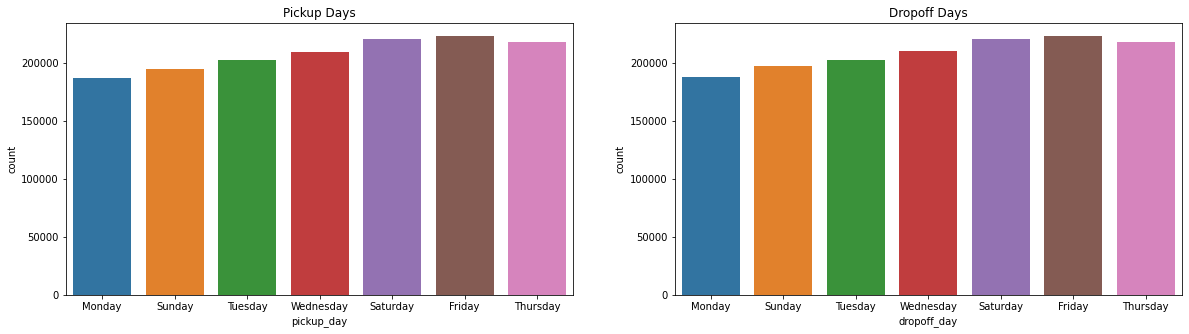

In [33]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=df,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=df,ax=ax2)

Trips per Hour

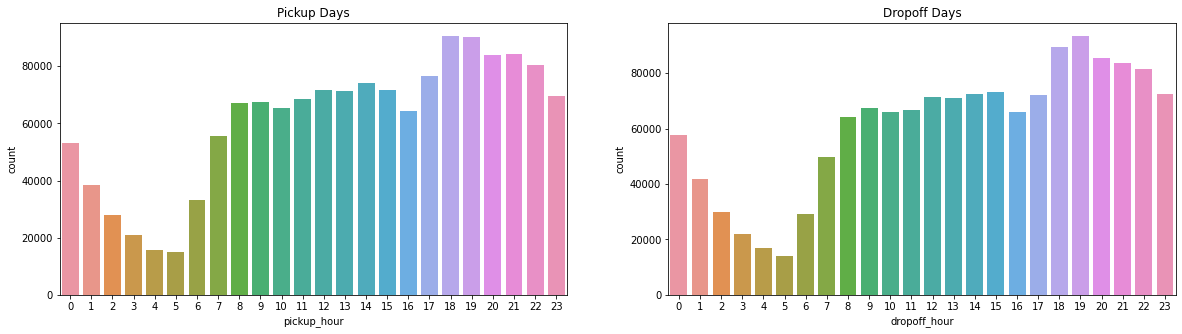

In [34]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))

ax9.set_title('Pickup Days')
ax=sns.countplot(x="pickup_hour",data=df,ax=ax9)

ax10.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax10)

Trips per Time of Day

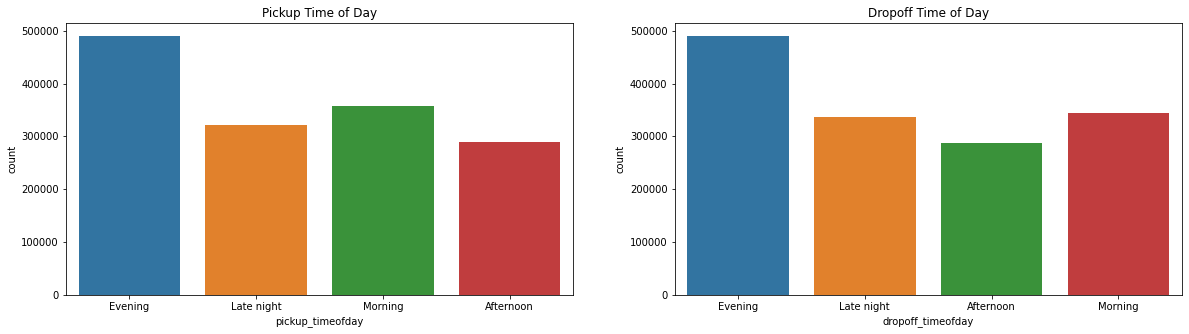

In [35]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))

ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=df,ax=ax3)

ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=df,ax=ax4)

Trips per month

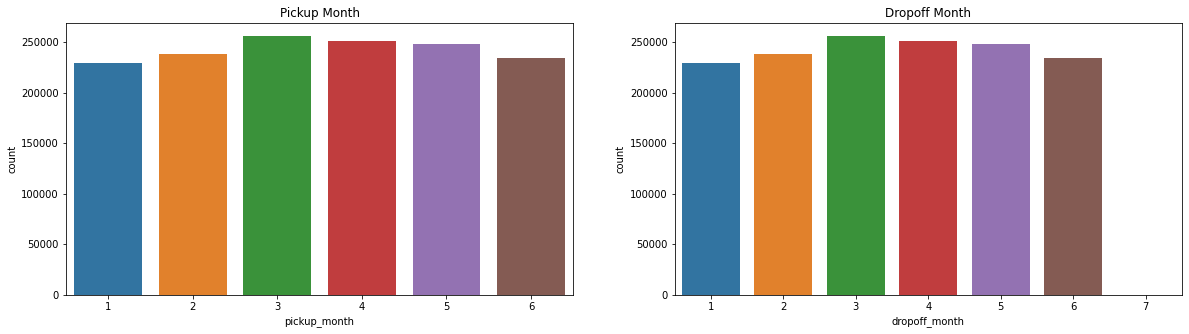

In [36]:
figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))

ax11.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=df,ax=ax11)

ax12.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=df,ax=ax12)

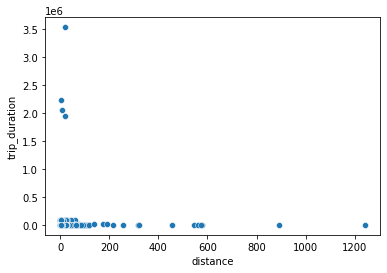

In [37]:
sns.scatterplot(x='distance',y='trip_duration',data=df)

In [38]:
X = df.drop(columns=["trip_duration"])

In [39]:
X.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,distance,trip_duration_in_hour,avg_speed_kph
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,17,17,3,3,Evening,Evening,1.498523,0.126389,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,0,0,6,6,Late night,Late night,1.805510,0.184167,9.803673
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,11,12,1,1,Morning,Afternoon,6.385108,0.590000,10.822216
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,19,19,4,4,Evening,Evening,1.485501,0.119167,12.465739
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5,13,13,3,3,Afternoon,Afternoon,1.188590,0.120833,9.836608


In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458579 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id                     1458579 non-null  object        
 1   vendor_id              1458579 non-null  int64         
 2   pickup_datetime        1458579 non-null  datetime64[ns]
 3   dropoff_datetime       1458579 non-null  datetime64[ns]
 4   passenger_count        1458579 non-null  int64         
 5   pickup_longitude       1458579 non-null  float64       
 6   pickup_latitude        1458579 non-null  float64       
 7   dropoff_longitude      1458579 non-null  float64       
 8   dropoff_latitude       1458579 non-null  float64       
 9   store_and_fwd_flag     1458579 non-null  object        
 10  pickup_day             1458579 non-null  object        
 11  dropoff_day            1458579 non-null  object        
 12  pickup_day_no          14585

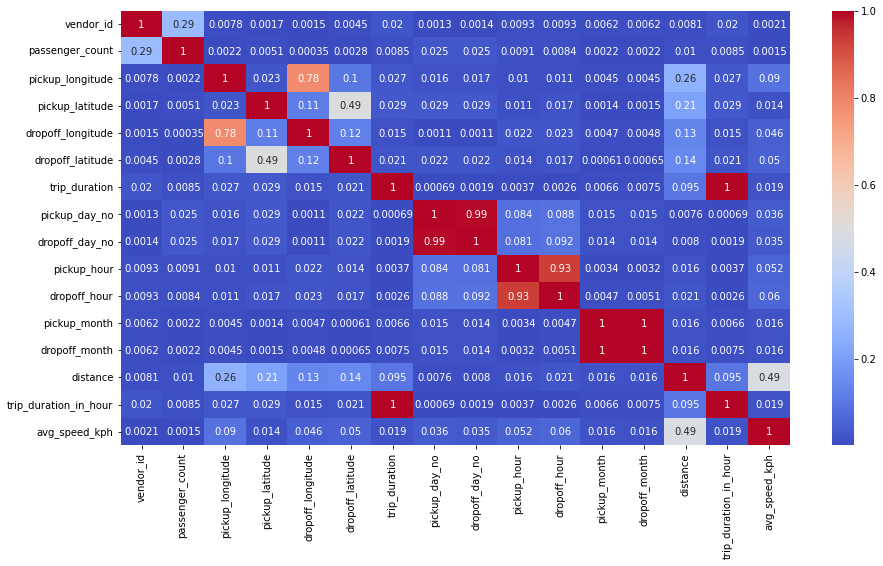

In [58]:
 ## Correlation
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [41]:
y = df['trip_duration']

In [42]:
# Creating list of catagorical columns
categorical_columns = X.select_dtypes(include = 'object').columns
categorical_columns

Index(['id', 'store_and_fwd_flag', 'pickup_day', 'dropoff_day',
       'pickup_timeofday', 'dropoff_timeofday'],
      dtype='object')

In [43]:
# Importing Encoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [44]:
# for converting our all object to integers or numeric value
for i in categorical_columns:
  X[i] = le.fit_transform(X[i])

In [45]:
X = X.drop(columns=["id"])

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458579 entries, 0 to 1458643
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   vendor_id              1458579 non-null  int64         
 1   pickup_datetime        1458579 non-null  datetime64[ns]
 2   dropoff_datetime       1458579 non-null  datetime64[ns]
 3   passenger_count        1458579 non-null  int64         
 4   pickup_longitude       1458579 non-null  float64       
 5   pickup_latitude        1458579 non-null  float64       
 6   dropoff_longitude      1458579 non-null  float64       
 7   dropoff_latitude       1458579 non-null  float64       
 8   store_and_fwd_flag     1458579 non-null  int64         
 9   pickup_day             1458579 non-null  int64         
 10  dropoff_day            1458579 non-null  int64         
 11  pickup_day_no          1458579 non-null  int64         
 12  dropoff_day_no         14585

Deleting 'pickup_datetime' and 'dropoff_datetime' feature from X bacause they are type of datetime.

In [47]:
X = X.drop(columns=['pickup_datetime','dropoff_datetime'])

In [48]:
X['store_and_fwd_flag'].value_counts()

0    1450537
1       8042
Name: store_and_fwd_flag, dtype: int64

Since "store_and_fwd_flag" column has very few value of 1 as compared to 0 so we can remove this column.

In [49]:
X = X.drop(columns=['store_and_fwd_flag'])

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458579 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vendor_id              1458579 non-null  int64  
 1   passenger_count        1458579 non-null  int64  
 2   pickup_longitude       1458579 non-null  float64
 3   pickup_latitude        1458579 non-null  float64
 4   dropoff_longitude      1458579 non-null  float64
 5   dropoff_latitude       1458579 non-null  float64
 6   pickup_day             1458579 non-null  int64  
 7   dropoff_day            1458579 non-null  int64  
 8   pickup_day_no          1458579 non-null  int64  
 9   dropoff_day_no         1458579 non-null  int64  
 10  pickup_hour            1458579 non-null  int64  
 11  dropoff_hour           1458579 non-null  int64  
 12  pickup_month           1458579 non-null  int64  
 13  dropoff_month          1458579 non-null  int64  
 14  pickup_timeofday  

In [51]:
X = X.drop(columns=['pickup_day','dropoff_day','dropoff_day_no','pickup_day_no','dropoff_hour','dropoff_month','dropoff_timeofday'])

In [52]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [53]:
rforest = RandomForestRegressor(n_estimators = 20, n_jobs = -1, random_state=42)

In [54]:
rforest = rforest.fit(X_train,y_train)
print(rforest)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)


In [55]:
# Predict
y_pred_rforest = rforest.predict(X_test)

In [56]:
# Score It
from sklearn import metrics
print('\nRandom Forest Regression Performance Metrics')
print('R^2 =',metrics.explained_variance_score(y_test,y_pred_rforest))
print('MAE',metrics.mean_absolute_error(y_test, y_pred_rforest))
print('MSE',metrics.mean_squared_error(y_test, y_pred_rforest))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test, y_pred_rforest)))


Random Forest Regression Performance Metrics
R^2 = 0.9999973352992069
MAE 0.047495852130154455
MSE 26.077530680524983
RMSE 5.106616363163086


In [57]:
print(y_pred_rforest)

[4965.4  382.   425.  ... 1813.  2267.   434. ]
